# Recommender System for Smartphone Business
**PROJECT OBJECTIVE:** To build a recommendation system using popularity based and collaborative filtering methods to recommend mobile phones to a user which are most popular and personalised respectively.

## 1. Import the necessary libraries and read the provided CSVs as a data frame and perform the below steps. 

**Set Environment and Import Libraries**

In [1]:
# Setting the warnings
import sys
import warnings                                 # `dnd` mode
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # Display all interactive output in jupyter

In [3]:
# Importing necessary libraries

from simple_colors import *                     # print text formatting 
from pprint import pprint                       # import petty print

import numpy as np                              # Import Numpy library for vectors, matrix, algebra
import pandas as pd                             # Import Pandas library for dataframe preparation and manipulation
import pandas_profiling
import glob                                     # finds pathnames according to the rules used by the Unix shell

from cleantext import clean                     # Create normalized text expression
import missingno as msno                        # Visualize the distribution of missing values

import matplotlib.pyplot as plt                 # Import Pyplot from matplotlib
import seaborn as sns                           # Import Seaborn library for data visualization
sns.set(color_codes = True)                     # data visualization
from sklearn.neighbors import LocalOutlierFactor # To detect outliers using Local Outlier Factor


from sklearn.model_selection import train_test_split as tts # scikit learn test train split
from scipy.sparse import csr_matrix
from scipy import stats

from surprise import Dataset, Reader            # Reader and dataset object import from surprise package
from surprise.model_selection import train_test_split # surprise train-test split
from surprise import SVD, KNNWithMeans                # surprise objects for SVD and KNNwithMeans CF
from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [4]:
%matplotlib inline

In [5]:
pd.options.display.max_colwidth = 50     # increase column width to display large text
pd.set_option("display.max_rows", None)   # set display of all rows
pd.options.display.float_format = '{:.2f}'.format

**Merge the provided CSVs into one data-frame**

In [6]:
path = r'/Users/kaushik/Desktop/data_RS_GL' # source folder where data is stored
all_files = glob.glob(path + "/*.csv")      # return a list of pathnames for .csv files
file_list = []                              # create an empty list type container for the data
for filename in all_files:
    data = pd.read_csv(filename, encoding="Latin-1")  # load csv files with encoding having 8-bit character set for western European languages
    file_list.append(data)                            # the for loop will load the data in the container

df = pd.concat(file_list, axis=0, ignore_index=True)  # merge all dataframes

**Check a few observations and shape of the data-frame**

In [7]:
df.head(5) # check first 5 observations in the dataframe

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.00,10.00,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.00,10.00,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.00,10.00,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.20,10.00,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.00,10.00,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [8]:
df.shape # check the shape of the data

(1415133, 11)

In [9]:
df.describe() # check the distribution of scores

,score,score_max
count,1351644.00,1351644.00
mean,8.01,10.00
std,2.62,0.00
min,0.20,10.00
25%,7.20,10.00
50%,9.20,10.00
75%,10.00,10.00
max,10.00,10.00


In [10]:
profile = pandas_profiling.ProfileReport(df)

This can be converted to html using the following, which provides interactive and extensive info on the data:
profile.to_file('/Users/kaushik/Desktop/profiler_GL6_metadata.html')

<AxesSubplot:xlabel='score', ylabel='Density'>

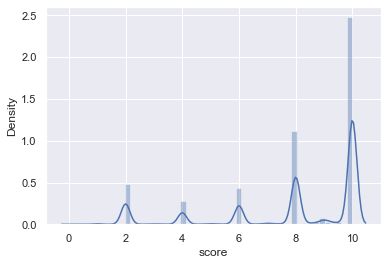

In [11]:
sns.distplot(df["score"])

**Round off scores to the nearest integers**

In [12]:
df[['score', 'score_max']] = df[['score', 'score_max']].apply(lambda x: round(x, 0)) # rounding off scores to zero decimal

<AxesSubplot:xlabel='score', ylabel='Density'>

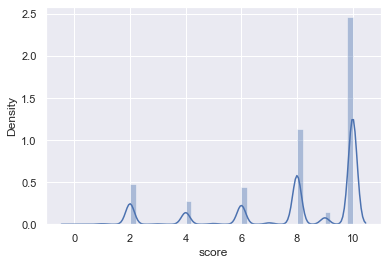

In [13]:
sns.distplot(df["score"]) # post-rounding off distribution

**Check for missing values. Impute the missing values if there is any**

A comprehensive analysis of the missing values are already available alongwith missingno visuals in the pandas profile report. I am again checking them here to show in the notebook the missing values and there relationships.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415133 entries, 0 to 1415132
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   phone_url  1415133 non-null  object 
 1   date       1415133 non-null  object 
 2   lang       1415133 non-null  object 
 3   country    1415133 non-null  object 
 4   source     1415133 non-null  object 
 5   domain     1415133 non-null  object 
 6   score      1351644 non-null  float64
 7   score_max  1351644 non-null  float64
 8   extract    1395772 non-null  object 
 9   author     1351931 non-null  object 
 10  product    1415132 non-null  object 
dtypes: float64(2), object(9)
memory usage: 118.8+ MB


In [15]:
print(blue("The number of columns having missing values in the dataframe ––", ['bold']))
len(df.columns[df.isnull().any()])

The number of columns having missing values in the dataframe ––


5

In [16]:
print(blue("The columns having missing values in the dataframe ––", ['bold']))
df.columns[df.isnull().sum() * 100/ len(df) > 0]

The columns having missing values in the dataframe ––


Index(['score', 'score_max', 'extract', 'author', 'product'], dtype='object')

In [17]:
print(blue("Max percentage of missing values in a column in the dataframe ––", ['bold']))
round((df.isnull().sum() * 100/ len(df)).max())

Max percentage of missing values in a column in the dataframe ––


4

Column-wise values present in the dataframe ––


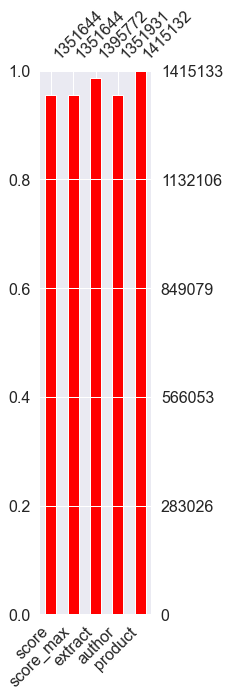

In [18]:
missing_df = df.columns[df.isnull().any()].tolist()
print(blue("Column-wise values present in the dataframe ––", ['bold']))
msno.bar(df[missing_df], color="red", figsize=(2,10));

Missing value pair heatmap ––


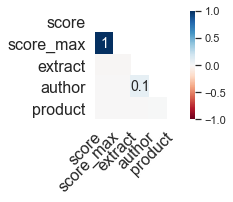

In [19]:
print(blue("Missing value pair heatmap ––", ['bold']))
msno.heatmap(df, figsize=(2,2)); 

For author and product columns, I will delete those record which have missing values (case deletion). I won't do any treatment of the missing values in extract column. I will impute the missing values of the score column with mode.

In [20]:
imputed_df = df.dropna(how='any', subset=['product', 'author'])

In [21]:
imputed_df["score"] = imputed_df["score"].fillna(imputed_df["score"].mode()[0])

In [22]:
imputed_df.isnull().sum()

phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score            0
score_max    60893
extract      15515
author           0
product          0
dtype: int64

**Check for duplicate values and remove them if there is any**

Removal of apparent duplicates

In [23]:
# Checking for a duplicate record
duplicate = imputed_df[imputed_df.duplicated()] # Selecting duplicate rows except first with occurrence based on all columns
print(blue("There are", ["bold"]), duplicate.shape[0], blue("duplicate rows or records in the data.", ["bold"]))

There are 5049 duplicate rows or records in the data.


In [24]:
row_to_drop = list(imputed_df[imputed_df.duplicated()].index.values)

In [25]:
analytical_df = imputed_df.drop(row_to_drop) # drop duplicate records by keeping only one instance

There can be additional records where author and products are same, while the other attributes may be different. I will remove those records as well.

In [26]:
print(blue("The number of duplicate rows or records in the data.", ["bold"]), len(analytical_df[analytical_df[['product', 'author']].duplicated()]))

The number of duplicate rows or records in the data. 159314


In [27]:
row_to_drop_2 = list(analytical_df[analytical_df[['product', 'author']].duplicated()].index.values)

In [28]:
analytical_df = analytical_df.drop(row_to_drop_2) # drop duplicate records by keeping only one instance

In [29]:
analytical_df.shape

(1187568, 11)

**Keep only 1000000 data samples**
(Use random state=612)

In [30]:
sample_df = analytical_df.sample(n = 1000000, random_state=612) 

**Drop irrelevant features. Keep features like Author, Product, and Score**

In [31]:
features_to_keep = ["author", "product", "score"]
sample_df = sample_df[features_to_keep]

## 2. Answer the following questions

**Identify the most rated product**

In [32]:
print(blue("Top 5 most frequently rated products", ["bold"]))
sample_df.groupby("product").size().sort_values(ascending=False).head(5)

Top 5 most frequently rated products


product
OnePlus 3 (Graphite, 64 GB)          1817
Lenovo Vibe K4 Note (White,16GB)     1720
Nokia N95                            1521
Lenovo Vibe K4 Note (Black, 16GB)    1517
OnePlus 3 (Soft Gold, 64 GB)         1482
dtype: int64

In [33]:
print(blue("Top 10 products having highest average ratings", ["bold"]))
pd.DataFrame(sample_df.groupby('product')['score'].mean().sort_values(ascending=False).head(10) )

Top 10 products having highest average ratings


,score
product,
éå±¬ + ç®é© = è³ªææ»¿åãWave 723 è©³æ¸¬åå¿å¾,10.00
Samsung Galaxy S7 edge 32GB smartphone - sort,10.00
"Samsung Galaxy S8 (64GB, Midnight Black)",10.00
Samsung Galaxy S8 (Ð¶ÐµÐ»ÑÑÐ¹ ÑÐ¾Ð¿Ð°Ð·),10.00
Samsung Galaxy S8 (Ð¼Ð¸ÑÑÐ¸ÑÐµÑÐºÐ¸Ð¹ Ð°Ð¼ÐµÑÐ¸ÑÑ),10.00
Samsung Galaxy S8 (ÑÐµÑÐ½ÑÐ¹ Ð±ÑÐ¸Ð»Ð»Ð¸Ð°Ð½Ñ),10.00
Samsung Galaxy S8 64GB Sort,10.00
Samsung Galaxy S8 64GB Svart,10.00
Samsung Galaxy S8 64GB SÃ¸lv,10.00


In [34]:
product_data = pd.DataFrame(sample_df.groupby('product')['score'].mean())

In [35]:
# dataframe of products that had user rating as 10
top_rated_products = product_data[product_data["score"] == 10]

**Identify the users with most number of reviews**

In [36]:
print(blue("Top 5 users with most number of reviews", ["bold"]))
pd.DataFrame(sample_df.groupby("author").size().sort_values(ascending=False).head(10)) 

Top 5 users with most number of reviews


,0
author,
Amazon Customer,6978
Cliente Amazon,2629
Anonymous,1040
Client d'Amazon,995
Amazon Kunde,869
David,701
Alex,640
Daniel,556
Chris,518


**Select the data with products having more than 50 ratings and users who have given more than 50 ratings. Report the shape of the final dataset**

In [37]:
prod_count = pd.value_counts(sample_df['product'])
auth_count = pd.value_counts(sample_df['author'])

In [38]:
rating_subset = sample_df[sample_df["product"].isin(prod_count[prod_count > 50].index)][sample_df["author"].isin(auth_count[auth_count > 50].index)]

In [39]:
print(blue("Shape of the final dataset", ["bold"]))
rating_subset.shape

Shape of the final dataset


(37900, 3)

In [40]:
rating_subset[["score"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
score,37900.00,8.15,2.60,1.00,8.00,10.00,10.00,10.00


In [41]:
print('The minimum rating is: %d' %(rating_subset["score"].min()))
print('The maximum rating is: %d' %(rating_subset["score"].max()))

The minimum rating is: 1
The maximum rating is: 10


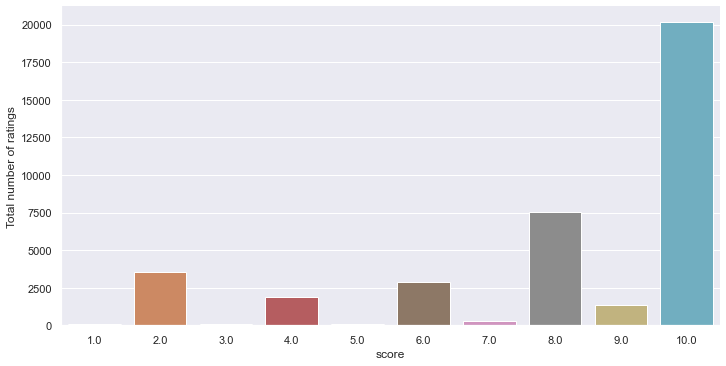

In [42]:
# Check the distribution of ratings in sampled data
g = sns.factorplot("score", data=rating_subset, aspect=2.0,kind='count')
g.set_ylabels("Total number of ratings");

In [43]:
# Number of unique authors and product in the data
print('Number of unique Authors in Raw data = ', rating_subset["author"].nunique())
print('Number of unique Products in Raw data = ', rating_subset["product"].nunique())

Number of unique Authors in Raw data =  692
Number of unique Products in Raw data =  4077


In [44]:
ratings_matrix = rating_subset.pivot("author", "product", "score").fillna(0)

In [45]:
sparse_mat = csr_matrix(ratings_matrix.values) # sparse matrix building
print('Shape of ratings matrix: ', ratings_matrix.shape)
print('Shape of sparse matrix: ', sparse_mat.shape)

Shape of ratings matrix:  (692, 4077)
Shape of sparse matrix:  (692, 4077)


In [46]:
sparse_mat.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.]])

In [47]:
num_of_ratings = np.count_nonzero(ratings_matrix)
print('The given number of ratings : ', num_of_ratings)

possible_ratings = ratings_matrix.shape[0] * ratings_matrix.shape[1]
print('The possible number of ratings : ', possible_ratings)

density = (num_of_ratings/possible_ratings)
density *= 100
print ("The density of ratings: {:4.2f}%".format(density))

The given number of ratings :  37900
The possible number of ratings :  2821284
The density of ratings: 1.34%


In [48]:
ratings_mean_count = pd.DataFrame(rating_subset.groupby("product")["score"].mean()) 
ratings_mean_count['rating_counts'] = pd.DataFrame(rating_subset.groupby("product")["score"].count())  
pop_table = ratings_mean_count.reset_index()
pop_table.sort_values(by="score", ascending=False).head()

,product,score,rating_counts
376,BLU Studio 6.0 HD Smartphone - GSM Unlocked - ...,10.00,2
1477,Lenovo A850,10.00,2
323,"Asus Zenfone 6 A600CG/A601CG (Red, 16GB)",10.00,1
2513,SAMSUNG Galaxy S5 - noir - 16 Go - Smartphone,10.00,1
2515,SAMSUNG Galaxy S6 Edge Plus - gold - 32 Go - 4...,10.00,1


**Simple popularity based recommender system**

In [49]:
train_data, test_data = tts(rating_subset, test_size = 0.20, random_state=612)

In [50]:
train_table = pd.DataFrame(train_data.groupby("product")["score"].mean()) 

In [51]:
train_table_reset = train_table.reset_index()

In [52]:
train_table_popularity = train_table_reset.sort_values(by="score", ascending=False)

In [53]:
train_table_popularity["Rank"] = train_table_popularity["score"].rank(ascending=0, method='first')

In [54]:
#Get the top 5 recommendations 
popularity_rs = train_table_popularity.head(5) 
popularity_rs

,product,score,Rank
2725,Samsung Galaxy J5 SM-J500H/DS GSM Factory Unlo...,10.00,1.00
1548,"Microsoft Lumia 435 (Dual SIM, Black)",10.00,2.00
3225,Samsung Knack U310 Flip Phone for Verizon Wire...,10.00,3.00
1563,"Microsoft Lumia 640 (Black, 8GB)",10.00,4.00
3230,Samsung N7100 Galaxy Note II (16Gb),10.00,5.00


In [55]:
# Use popularity based recommender model to make predictions
def pop_recommend(author):     
    user_recommendations = popularity_rs 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations["author"] = "author" 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [56]:
test_auth = test_data["author"].tolist()

In [57]:
find_recom = test_auth[0:3]   # This list of first three authors in test data
for i in find_recom:
    print("Here is the recommendation for the author: \n", i)
    print(pop_recommend(i))    
    print("\n") 

Here is the recommendation for the author: 
 ÐÐ»ÐµÐºÑÐ°Ð½Ð´Ñ
      author                                            product  score  Rank
2725  author  Samsung Galaxy J5 SM-J500H/DS GSM Factory Unlo...  10.00  1.00
1548  author              Microsoft Lumia 435 (Dual SIM, Black)  10.00  2.00
3225  author  Samsung Knack U310 Flip Phone for Verizon Wire...  10.00  3.00
1563  author                   Microsoft Lumia 640 (Black, 8GB)  10.00  4.00
3230  author                Samsung N7100 Galaxy Note II (16Gb)  10.00  5.00


Here is the recommendation for the author: 
 Daniel
      author                                            product  score  Rank
2725  author  Samsung Galaxy J5 SM-J500H/DS GSM Factory Unlo...  10.00  1.00
1548  author              Microsoft Lumia 435 (Dual SIM, Black)  10.00  2.00
3225  author  Samsung Knack U310 Flip Phone for Verizon Wire...  10.00  3.00
1563  author                   Microsoft Lumia 640 (Black, 8GB)  10.00  4.00
3230  author                Samsung

**Popularity-based recommender system based on weighted score**

In [58]:
rating_subset.head()

,author,product,score
1266001,Thomas,"Emporia Elegance Handy (4,6 cm (1,8 Zoll), OLE...",10.00
501669,fabio,"HOMTOM HT7 3G WCDMA 5.5 ""IPS smartphone Androi...",8.00
444141,rpv,Google LG Nexus 5 D820 GSM Unlocked Smartphone...,8.00
699633,antonio,"Samsung I9505 Galaxy S4 Smartphone, 16 GB [Ita...",10.00
496566,mario,"Wiko Rainbow Smartphone (12,7 cm (5 Zoll) Disp...",10.00


In [59]:
train_data_2, test_data_2 = tts(rating_subset, test_size = 0.20, random_state=42)

In [60]:
ratings_mean_count_2 = pd.DataFrame(train_data_2.groupby("product")["score"].mean()) 
ratings_mean_count_2['sum_score'] = pd.DataFrame(train_data_2.groupby("product")["score"].sum())
ratings_mean_count_2['rating_counts'] = pd.DataFrame(train_data_2.groupby("product")["score"].count())  
pop_table_2 = ratings_mean_count_2.reset_index()
pop_table_2.sort_values(by="score", ascending=False).head()

,product,score,sum_score,rating_counts
3407,Siemens MC60,10.00,10.00,1
1155,LG Electronics L7 II Sim Free Smartphone,10.00,10.00,1
2342,Nokia Microsoft Lumia 535 Smartphone dÃ©bloquÃ...,10.00,10.00,1
1182,LG G Vista (Verizon Prepaid),10.00,20.00,2
461,BlackBerry Pearl Flip 8220,10.00,10.00,1


In [61]:
# calculate mean of score average
C = (pop_table_2["sum_score"].sum())/(pop_table_2["rating_counts"].sum())
print(C)

8.148647757255937


In [62]:
# minimum number of ratings required to be in the chart, m=50
m = 50

In [63]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x["rating_counts"]
    R = x["score"]
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [64]:
# Define a new feature 'score' and calculate its value with weighted_rating()
pop_table_2["wt. score"] = pop_table_2.apply(weighted_rating, axis=1)

In [65]:
#Sort movies based on score calculated above
pop_table_2 = pop_table_2.sort_values("wt. score", ascending=False)

#Print the top 10 movies
pop_table_2[["product", "rating_counts", "score", "wt. score"]].head(10)

,product,rating_counts,score,wt. score
1491,"Lenovo Motorola Moto G Smartphone, 4,5 pollici...",85,9.62,9.08
1492,"Lenovo Motorola Moto G Smartphone, Display HD ...",64,9.53,8.92
1487,"Lenovo Motorola Moto G LTE Smartphone, Display...",58,9.45,8.85
2643,Samsung Galaxy A5,30,9.93,8.82
1028,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...",98,9.14,8.81
7,"APPLE iPhone 6s Plus - 128 GB, Rose Gold",43,9.56,8.80
2218,Nokia E51 Cep Telefonu,27,10.00,8.80
1421,LG X power (Ð±ÐµÐ»ÑÐ¹),28,9.93,8.79
3101,Samsung Galaxy S7,27,9.93,8.77
2645,Samsung Galaxy A5 (2016),35,9.66,8.77


In [66]:
pop_table_2["Rank"] = pop_table_2["wt. score"].rank(ascending=0, method='first')

In [67]:
#Get the top 5 recommendations 
popularity_rs_2 = pop_table_2[["product", "wt. score"]].head(5) 
popularity_rs_2

,product,wt. score
1491,"Lenovo Motorola Moto G Smartphone, 4,5 pollici...",9.08
1492,"Lenovo Motorola Moto G Smartphone, Display HD ...",8.92
1487,"Lenovo Motorola Moto G LTE Smartphone, Display...",8.85
2643,Samsung Galaxy A5,8.82
1028,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...",8.81


In [68]:
# Use popularity based recommender model to make predictions
def wt_pop_recommend(author):     
    user_recommendations = popularity_rs_2 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations["author"] = "author" 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [69]:
test_auth_2 = test_data_2["author"].tolist()

In [70]:
find_recom = test_auth_2[0:3]   # This list of first three authors in test data
for i in find_recom:
    print("Here is the recommendation for the author: \n", i)
    print(wt_pop_recommend(i))    
    print("\n") 

Here is the recommendation for the author: 
 Manuela
      author                                            product  wt. score
1491  author  Lenovo Motorola Moto G Smartphone, 4,5 pollici...       9.08
1492  author  Lenovo Motorola Moto G Smartphone, Display HD ...       8.92
1487  author  Lenovo Motorola Moto G LTE Smartphone, Display...       8.85
2643  author                                  Samsung Galaxy A5       8.82
1028  author  Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...       8.81


Here is the recommendation for the author: 
 Jorge
      author                                            product  wt. score
1491  author  Lenovo Motorola Moto G Smartphone, 4,5 pollici...       9.08
1492  author  Lenovo Motorola Moto G Smartphone, Display HD ...       8.92
1487  author  Lenovo Motorola Moto G LTE Smartphone, Display...       8.85
2643  author                                  Samsung Galaxy A5       8.82
1028  author  Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...      

## 4. Build a collaborative filtering model using SVD. You can use SVD from surprise or build it from scratch

(Note: Incase you’re building it from scratch you can limit your data points to 5000 samples if you face memory issues). 
Build a collaborative filtering model using kNNWithMeans from surprise. You can try both user-based and item-based model.

In [71]:
sample_df_2 = analytical_df.sample(n = 50000, random_state=612)  # I have used 50,000 samples instead of 5,000
data_2 = sample_df_2[features_to_keep]

To improve the predictions I will use here some text processing, which will fix the unicode errors, transliterate values to nearest ASCII, lowercase chracters.

In [72]:
data_2["product"] = data_2["product"].apply(lambda x: clean(str(x),
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,            # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                   # replace all URLs with a special token
    no_emails=True,                 # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    lang="en"                       
)) 

In [73]:
data_2["author"]= data_2["author"].astype(str) # converting each author value to string format
data_2['author'] = data_2['author'].map(lambda x: x.lower()) # converting to lowercase 

In [74]:
counts1 = pd.value_counts(data_2["author"])

In [75]:
data_2 = data_2[data_2["author"].isin(counts1[counts1 > 5].index)] # selecting data for users who have rated at least 5 products

In [76]:
data_2.shape

(4231, 3)

In [77]:
reader = Reader(rating_scale=(1, 10)) # creating a reader object with given range of scores between 0 to 10 as found earlier
data_surprise = Dataset.load_from_df(data_2[["author", "product", "score"]], reader)

In [78]:
trainset, testset = train_test_split(data_surprise, test_size=.25,random_state=123)

In [79]:
trainset.all_ratings()

<generator object Trainset.all_ratings at 0x7fe828d18190>

In [80]:
print(trainset.to_raw_uid(0))

cliente amazon


In [81]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  344 

Number of items:  2665 



During train-test split surprise creates a Trainset or Testset object, that takes the raw ids, and converts them to inner_ids, which are a series of integers, starting from 0. To convert to raw ids we can use to_raw_iid and thereby map each inner id against corresponding raw id.

In [82]:
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

**The difference between user based and item based collaborative filtering is that, in item-based filtering, the similarity between the co-rated items are directly calculated skipping K-neighborhood search.**

**SVD based recommender system**

In [83]:
svd_model = SVD(n_factors=5,biased=False)
svd_model.fit(trainset)

**KNNwithMeans**

**a) Item-based**

In [84]:
my_k = 20
my_min_k = 5
my_sim_option = {'name':'cosine', 'user_based':False}

In [85]:
knn_model = KNNWithMeans(k = my_k, min_k = my_min_k, sim_option = my_sim_option)
knn_model.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


**b) User-based**

In [86]:
my_sim_option_2 = {'name':'pearson', 'user_based':True} # here I have also changed the similarity from cosine to pearson for demonstration

In [87]:
knn_model_2 = KNNWithMeans(k = my_k, min_k = my_min_k, sim_option = my_sim_option_2)
knn_model_2.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


## 5. Evaluate the collaborative model. Print RMSE value.

In [88]:
test_pred_svd = svd_model.test(testset)
print("Accuracy of SVD model")
accuracy.rmse(test_pred_svd)

Accuracy of SVD model
RMSE: 4.6371


4.637132590753582

In [89]:
test_pred_knn = knn_model.test(testset)
print("Accuracy of KNNwithMeans model (content)")
accuracy.rmse(test_pred_knn)

Accuracy of KNNwithMeans model (content)
RMSE: 2.6296


2.6295696070781553

In [90]:
test_pred_knn_2 = knn_model_2.test(testset)
print("Accuracy of KNNwithMeans model (user)")
accuracy.rmse(test_pred_knn_2)

Accuracy of KNNwithMeans model (user)
RMSE: 2.6296


2.6295696070781553

Inference: KNNwithMeans performed better

## 6. Predict score (average rating) for test users. 

In [91]:
knn_pred = pd.DataFrame(test_pred_knn_2)

In [92]:
knn_pred_item = pd.DataFrame(test_pred_knn)

In [93]:
svd_pred = pd.DataFrame(test_pred_svd)

In [94]:
knn_pred.head()

,uid,iid,r_ui,est,details
0,ð¯ð½ð°,sony xperia z (),10.00,9.25,"{'actual_k': 0, 'was_impossible': False}"
1,ðð½ñð¾ð½,samsung s8600 wave 3,7.00,8.09,"{'was_impossible': True, 'reason': 'User and/o..."
2,paul,samsung sgh-t659 cell phone t-mobile,8.00,8.09,"{'was_impossible': True, 'reason': 'User and/o..."
3,ed,"lg d855 g3 smartphone, 16 gb, nero metallico [...",10.00,7.33,"{'actual_k': 0, 'was_impossible': False}"
4,domenico,nokia x2-02,10.00,8.09,"{'was_impossible': True, 'reason': 'User and/o..."


## 7. Report your findings and inferences

Popularity-based recommender system only provided non-customised results which are same for all users as the model does not take into account individual user preference. Collaborative filtering based model provided results which are tailored, meaning it is assumed that a given user would prefer mobiles which were purchased by people who had similar preferences. The KNNwithMeans model of collaborative filtering gave better results than the SVD model. KNN uses the distance while SVD uses matrix factorization. SVD was much faster but substantially worse in terms of errors in the given data based on RMSE values.

User-Based Filtering is based on the similarities between users. If a user has not given score for a mobile, the system will base its recommendations on similarities between the user and other users. Instead, Item-based system based its recommendations on similarities between items. Both performed similarly here. 

The final recommendation through KNN showed that for many users recommendations was not possible as the matrix was sparse, and there may be gray ship problem.

## 8. Try and recommend top 5 products for test users.

In [95]:
testset[0]

('ð¯ð½ð°', 'sony xperia z ()', 10.0)

In [96]:
uid = testset[0][0]  # raw user id (as in the ratings file). They are **strings**!

In [97]:
knn_pred[knn_pred['uid'] == uid][['iid', 'r_ui','est']].sort_values(by = 'r_ui',ascending = False).head(5)

,iid,r_ui,est
0,sony xperia z (),10.00,9.25
197,nokia 5230 xpressmusic,10.00,8.09


In [98]:
uid2 = testset[123][0]  # raw user id (as in the ratings file). They are **strings**!

In [99]:
knn_pred[knn_pred['uid'] == uid2][['iid', 'r_ui','est']].sort_values(by = 'r_ui',ascending = False).head(5)

,iid,r_ui,est
7,"blackberry z10 smartphone (4,2 zoll display, t...",10.00,8.09
123,"samsung galaxy j5 smartphone, oro [italia]",10.00,8.09
251,"microsoft nokia 7230 handy (3.2 mp, musikplaye...",8.00,8.09
809,smartphone lg l90 dual d410 preto com tela de ...,8.00,9.11
330,"samsung galaxy s advance, display 4 pollici, w...",6.00,8.09


## 9. Check for outliers and impute them as required

<AxesSubplot:xlabel='score'>

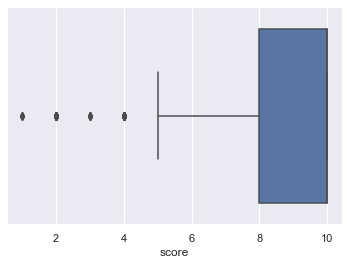

In [100]:
sns.boxplot(x=data_2["score"])

In [101]:
Q1 = data_2["score"].quantile(0.25)
Q3 = data_2["score"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

2.0


In [102]:
df_out = data_2[((data_2["score"] < (Q1 - 1.5 * IQR)) |(data_2["score"] > (Q3 + 1.5 * IQR)))]
df_out.shape

(660, 3)

In [103]:
data_2.shape

(4231, 3)

In [104]:
row_to_impute = list(data_2[((data_2["score"] < (Q1 - 1.5 * IQR)) |(data_2["score"] > (Q3 + 1.5 * IQR)))].index.values)

In [105]:
impute_value = np.median(data_2["score"])

In [106]:
for i in row_to_impute:
    data_2.at[i, "score"] = impute_value

In [107]:
data_surprise = Dataset.load_from_df(data_2[["author", "product", "score"]], reader)

In [108]:
trainset, testset = train_test_split(data_surprise, test_size=0.3)

In [109]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  344 

Number of items:  2492 



In [110]:
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

In [111]:
my_k = 20
my_min_k = 5
my_sim_option = {'name':'cosine', 'user_based':False}

In [112]:
knn_model = KNNWithMeans(k = my_k, min_k = my_min_k, sim_option = my_sim_option)
knn_model.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [113]:
test_pred_knn = knn_model.test(testset)
print("Accuracy of KNNwithMeans model (content)")
accuracy.rmse(test_pred_knn)

Accuracy of KNNwithMeans model (content)
RMSE: 1.2612


1.2612012241206916

## 10. Try cross validation techniques to get better results

In [114]:
results = cross_validate(
    algo = knn_model, data = data_surprise, measures=['RMSE'], 
    cv=10, return_train_measures=True
    )

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [115]:
test_pred_algo = knn_model.test(testset)
accuracy.rmse(test_pred_algo)

RMSE: 1.1728


1.1727944717252388

**hyperparameter tuning using GridSearchCV**

In [116]:
param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data_surprise)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.2443501574751556
{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.4}


In [117]:
sim_options = {
    "name": ["msd", "cosine", "pearson"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs2 = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs2.fit(data_surprise)

print(gs2.best_score["rmse"])
print(gs2.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

## 11. In what business scenario you should use popularity based Recommendation Systems ?

Popularity based recommender system only provides the recommended mobiles based on general mobile popularity, not based on particular use test. It will be particularly useful at the beginning or start of the mobile business, when there is lack of historical user data. It thus overcomes the cold start problem. However as it provides same mobile recommendations to all users, the recommendations can often be wrong especially for users who have niche or specific interests. 

## 12. In what business scenario you should use CF based Recommendation Systems ?

Collaborative filtering based recommendation systems look into the users data, the item used. Therefore, they checks the taste of similar users and provide tailored recommendations. However, if there are not enough users, i.e., the cold start problem, the model cannot find a match. Also if the user and rating matrix is sparse in spite of many users or items, a reliable model cannot be developed. One particular challenge is gray ship problem, in which one user may have an item profile based on which no mobile can be recommended to him or her, since others have not used the same. I would use it in established mobile businesses especially when the matrix is not sparse. 

## 13. What other possible methods can you think of which can further improve the recommendation for different users?

**Methods to improve recommendations:**
1. **Data preprocessing**
* Text cleaning: fixing unicode errors, transliteration to nearest ASCII, lowercase text, no currency symbol, no punctuation, etc.
* Variance check for matrix and treatment for skewness.
* Use of fuzzymatching techniques for textual data.
2. **Model**
* Use of regularization to avoid overfitting
* Use of bias terms to minimize the error between actual and predicted value
* Increasing the neighbourhood, i.e., the model size
* Switching from user based to item based model for sparse matrix
* Use of weighting: for example, giving more weightage to recent ratings (time weighting)
* Content based models can overcome the cold start and grey ship problems of collaborative filtering.
3. **Hybridization**
* weighted: recommedations from different systems are weighted to get final recommendation
* switching: system switches between different models
* mixed:recommendations from different systems are shown together
* One common approach is to combine content based and CF models.
